# Random walks on the spanning cluster

In this notebook we'll explore diffusion on the spanning cluster.

In [1]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage
import tqdm
import sklearn.linear_model

from generate_spanning_cluster import get_spanning_cluster
from percwalk import percwalk, parallel_percwalk
from log_binning import log_bin

In [2]:
sns.set(color_codes=True)

In [3]:
# Critical percolation probability
p_c = 0.59275

## Distance moved on the percolating cluster

We'll start by exploring diffusion on the percolating cluster for $p > p_c$. We'll measure the second moment of the average distance, $\langle R^2 \rangle$, as a function of the number of steps performed. Below we'll demonstrate what the diffusion on the percolating cluster looks like.

In [4]:
spanning_cluster = get_spanning_cluster(100, p_c)

Having created a system with a percolating cluster, we start by visualizing the spanning cluster.

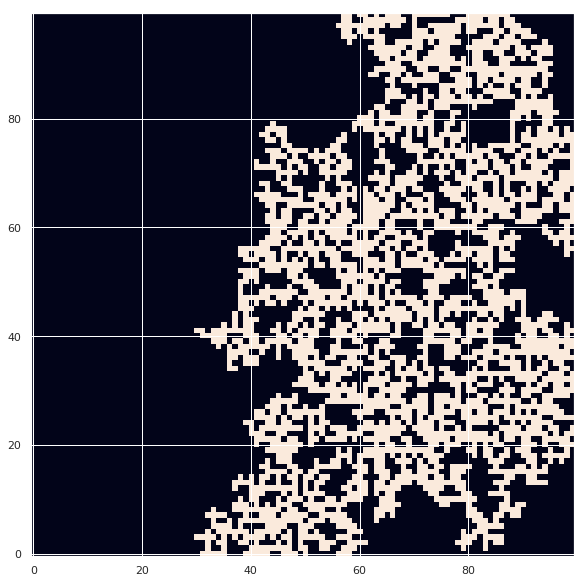

In [5]:
plt.figure(figsize=(14, 10))

plt.imshow(spanning_cluster, origin="lower")
plt.show()

Here we can see the sites contained in the percolating cluster. Moving on, we'll start a walker on a random site in the percolating cluster.

In [6]:
num_walks = int(1e5)
num_steps = 0

In [7]:
while num_steps <= 1:
    walker_map, displacements, num_steps = percwalk(spanning_cluster, num_walks)

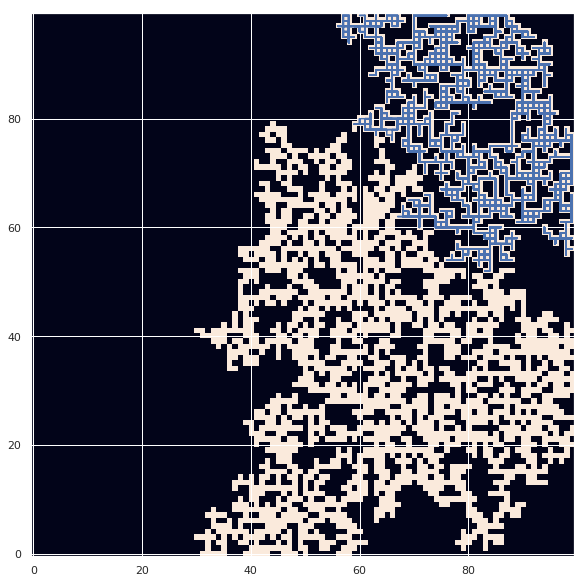

In [8]:
plt.figure(figsize=(14, 10))

plt.imshow(spanning_cluster, origin="lower")
# walker_map is oriented as row-column (ix, iy)
plt.plot(walker_map[1], walker_map[0])
plt.show()

In the above plot we can see how the walker moves in the spanning cluster. A thick line signifies several walks over a site.

## Mean squared distance

Next, we'll look at the mean squared distance, $\langle r^2 \rangle$, as a function of the number of walks, $N$, for varying $p > p_c$.
A free random walker behaves according to
\begin{align}
    \langle r^2 \rangle \propto D t,
\end{align}
as we've seen in the molecular dynamics simulations.
On the percolating cluster we expect that the random walker at times gets stuck in dangling ends or slows down through singly connected bonds.
We introduce the scaling theory
\beging{align}
    \langle r^2 \rangle = t^{2k} f\left[ (p - p_c) t^x \right],
\end{align}
for the mean squared distance on a system with random set sites.
We can categorize the function $f(u)$ for three different situations.
\begin{align}
    f(u) = \begin{cases}
        \text{const} & |u| \ll 1, \\
        u^{\mu} & u \gg 1, \\
        (-u)^{\beta - 2\nu} &  u \ll -1.
    \end{cases}
\end{align}
The first situation arises when $p \approx p_c$ and yields the scaling
\begin{align}
    \langle r^2 \rangle \propto t^{2k},
\end{align}
where $k < 1/2$.
This is known as _subdiffusion_ as opposed to the _superdiffusion_ observed for the initial molecular dynamics simulations.
The second situation $u \gg 1 \implies p > p_c$ and $t > t_0$, where $t_0$ is some threshold time.
This will yield the scaling theory
\begin{align}
    \langle r^2 \rangle \propto (p - p_c)^{\mu} t \propto t^{2k} \left[(p - p_c) t^{x} \right]^{\mu}.
\end{align}
The final situation is found when $p < p_c$ and $t > t_0$ yielding the scaling theory
\begin{align}
    \langle r^2 \rangle \propto (p_c - p)^{\beta - 2\nu} \propto t^{2k} \left[ (p_c - p) t^x \right]^{\beta - 2\nu}.
\end{align}
We will not be exploring the latter situation.
When $p > p_c$ and after a certain time $t_0$ has passed we expect the random walker on the cluster to behave as a normal free random walker.
That is, when $t \gg t_0$ we get
\begin{align}
    \langle r^2 \rangle \propto D t,
\end{align}
when $p > p_c$.
Stated differently, when $\langle r^2 \rangle \gg \xi^2$ the walker behaves as a free random walker.
The interesting fact here is that when $p = p_c$ we know that $\xi \to \infty$ and this condition will never be fullfilled.
This means that the scaling theory described above for the mean squared distance when $p = p_c$ will be true indefinitely.
We can summarize it by the function
\begin{align}
    \langle r^2 \rangle \propto \begin{cases}
        t^{2k} & \langle r^2 \rangle \ll \xi^2, \\
        D t & \langle r^2 \rangle \gg \xi^2.
    \end{cases}
\end{align}

We now simulate a system of size $L$ and compute the mean squared displacement on the spanning cluster several times for every system.

In [9]:
L = 1024
num_walks = 1 * int(1e5)
num_walks_arr = np.arange(num_walks)
p_arr = np.linspace(p_c, 0.8, 12)
num_walkers = 200
num_systems = 20

r_squared = np.zeros((len(p_arr), num_walks))

It is important to note that the implementation for the percolation walker we use require $2L^2 > N_w$, where $N_w$ is the number of walks (or, time if you like) we let the walkers perform. This is so that the walker won't start backtracking from whence it came thereby flattening the displacement curve.

In [10]:
for i, p in tqdm.tqdm_notebook(enumerate(p_arr), total=len(p_arr)):
    spanning_cluster = get_spanning_cluster(L, p, num_attempts=1000)
    r_squared[i] += parallel_percwalk(spanning_cluster, num_walks, num_walkers, num_systems)

Having computed the mean squared displacement for several different values of $p \geq p_c$ we look at the diffusion behavior.
For $p = p_c$ we know that $\xi \to \infty$ and we know that
\begin{align}
    \langle r^2(t) \rangle \propto t^{2k},
\end{align}
for all values of $t$ as we will never have $\langle r^2(t) \rangle \gg \xi^2$.
We therefore estimate $k$ by taking the logarithm on both sides of the equation and using linear regression.
\begin{gather}
    \log\left( \langle r^2(t) \rangle \right)
    = \log(C) + 2k \log(t),
\end{gather}
where $C$ is a constant serving as the intercept.

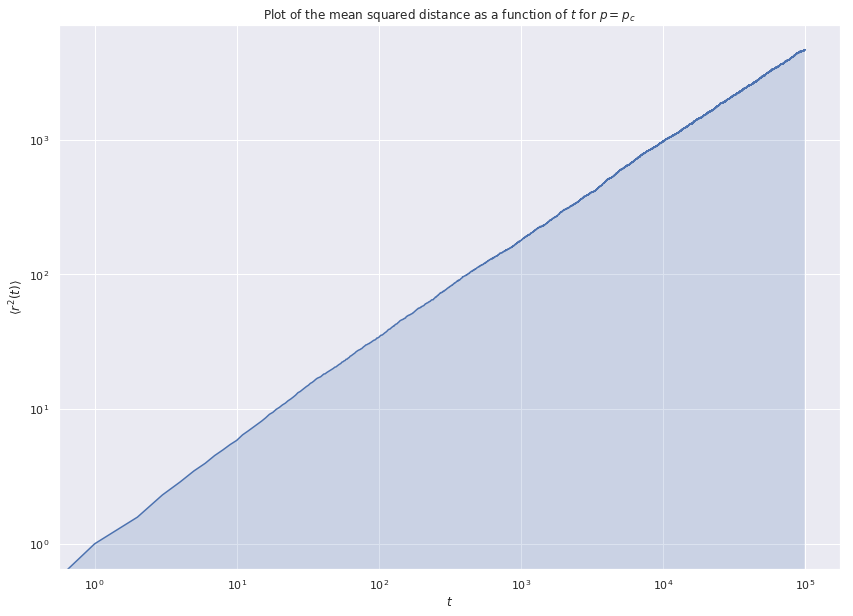

In [11]:
plt.figure(figsize=(14, 10))

plt.loglog(num_walks_arr, r_squared[0])
plt.fill_between(num_walks_arr, r_squared[0], alpha=0.2)
plt.xlabel(r"$t$")
plt.ylabel(r"$\langle r^2(t) \rangle$")
plt.title(r"Plot of the mean squared distance as a function of $t$ for $p = p_c$")
plt.show()

In this figure we can see how the log-log plot of the mean squared distance as a function of time for $p = p_c$ becomes linear.
We now use linear regression to find an estimate for $k$.

In [12]:
log_walks = np.log(num_walks_arr[1:])
log_r = np.log(r_squared[0, 1:])

clf = sklearn.linear_model.LinearRegression().fit(
    log_walks[:, np.newaxis], log_r[:, np.newaxis]
)

k = clf.coef_[0, 0] / 2
C = clf.intercept_[0]

print(f"k = {k}")

k = 0.3511114189201444


Having found the intercept and the coefficient $k$ we plot $\langle r^2(t) \rangle$ as a function of the number of walks (time, in a sense) and compare it to the theoretical estimate.

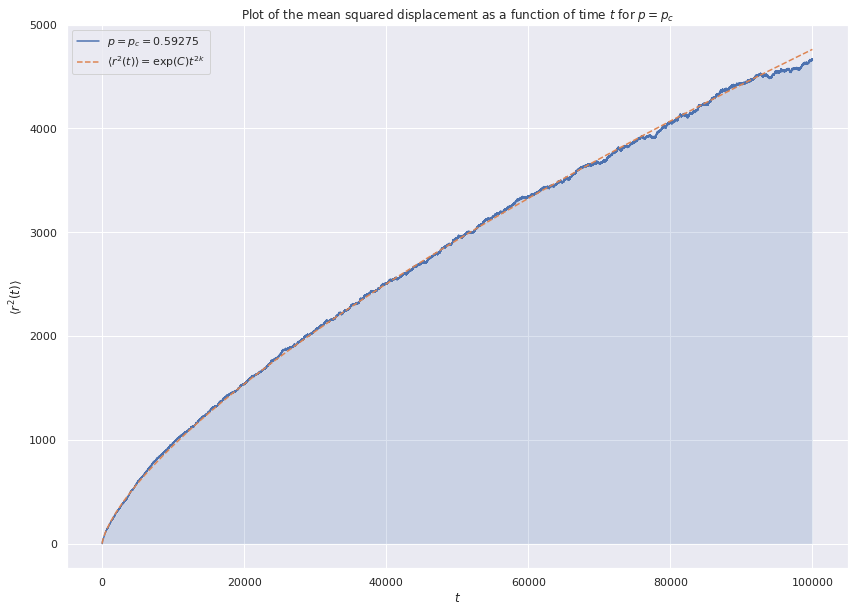

In [13]:
plt.figure(figsize=(14, 10))

plt.plot(
    num_walks_arr,
    r_squared[0],
    label=rf"$p = p_c = {p_c}$",
)
plt.fill_between(num_walks_arr, r_squared[0], alpha=0.2)

plt.plot(
    num_walks_arr,
    np.exp(C) * num_walks_arr ** (2 * k),
    "--",
    label=r"$\langle r^2(t) \rangle = \exp(C) t^{2k}$",
)


plt.title(r"Plot of the mean squared displacement as a function of time $t$ for $p = p_c$")
plt.xlabel(r"$t$")
plt.ylabel(r"$\langle r^2(t) \rangle$")
plt.legend(loc="best")
plt.show()

In this figure we have plotted the mean squared displacement as a function of "time", i.e., the number of walks, on the spanning cluster for $p = p_c$.
We observe the expected subdiffusion.
We also see how the theoretical estimate of the subdiffusion follows the data closely.
Below we plot the mean squared distance for $p \geq p_c$.

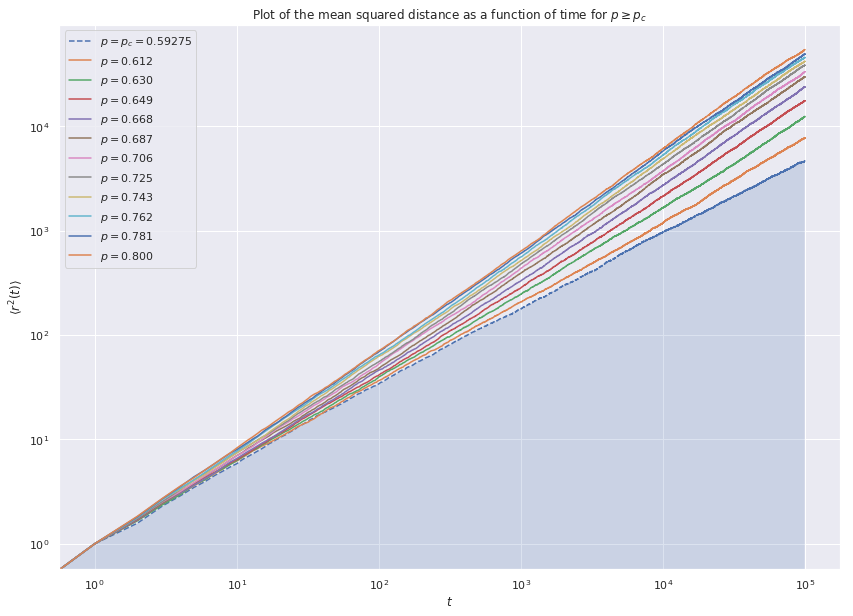

In [14]:
plt.figure(figsize=(14, 10))

plt.loglog(
    num_walks_arr,
    r_squared[0],
    "--",
    label=rf"$p = p_c = {p_c}$",
)
plt.fill_between(num_walks_arr, r_squared[0], alpha=0.2)

for i, p in enumerate(p_arr[1:]):
    plt.loglog(
        num_walks_arr,
        r_squared[i + 1],
        label=rf"$p = {p:.3f}$"
    )

plt.legend(loc="best")
plt.xlabel(r"$t$")
plt.ylabel(r"$\langle r^2(t) \rangle$")
plt.title(r"Plot of the mean squared distance as a function of time for $p \geq p_c$")
plt.show()

In the above figure we see how after a time $t_0$ the mean squared distance for $p > p_c$ deviates from the situation when $p = p_c$.
Reformulating the scaling theory for $p > p_c$ to create a data collapse we get
\begin{gather}
    \langle r^2 \rangle \propto t^{2k} (p - p_c) t^{x}
    \implies
    t^{-2k} \langle r^2 \rangle \propto (p - p_c) t^{x}.
\end{gather}
We plot this on a log-log axis when creating the data collapse.
However, the challenge is to find an expression for $x$.
We have previously found that
\begin{align}
    \langle r^2(t) \rangle D(p) t,
\end{align}
where $D(p) = (p - p_c)^{\mu}$ when $p > p_c$ and $r \gg \xi$.
Inserted into the scaling theory we can write
\begin{gather}
    (p - p_c)^{\mu} t \propto t^{2k} \left[(p - p_c) t^{x}\right]^{\mu}
    \implies
    1 = 2k + \mu x
    \implies
    x = \frac{1 - 2k}{\mu}.
\end{gather}
Having already found $k$ we are thus tasked with finding an expression for $\mu$ and we can be on our merry way to plotting a data collapse.

We know that when $t < t_0$ the mean squared distance scales as $t^{2k}$ when $p = p_c$ and $p > p_c$.
However, when $t > t_0$ this scaling continues only for $p = p_c$ whereas for $p > p_c$ the mean squared distance will increase faster in time.
We are interested in locating $t_0$ and we do this by finding the point where
\begin{align}
    \langle r^2(t; p_c) \rangle \leq \frac{1}{2} \langle r^2(t; p > p_c) \rangle,
\end{align}
that is, we find the point where the scaling is more than twice as high.
At $t = t_0$ we know that $\langle r^2(t_0) \rangle = \xi^2$.
We are lucky enough to have a scaling ansatz for the characteristic cluster length stating
\begin{align}
    \xi = \xi_0 (p - p_c)^{-\nu}.
\end{align}

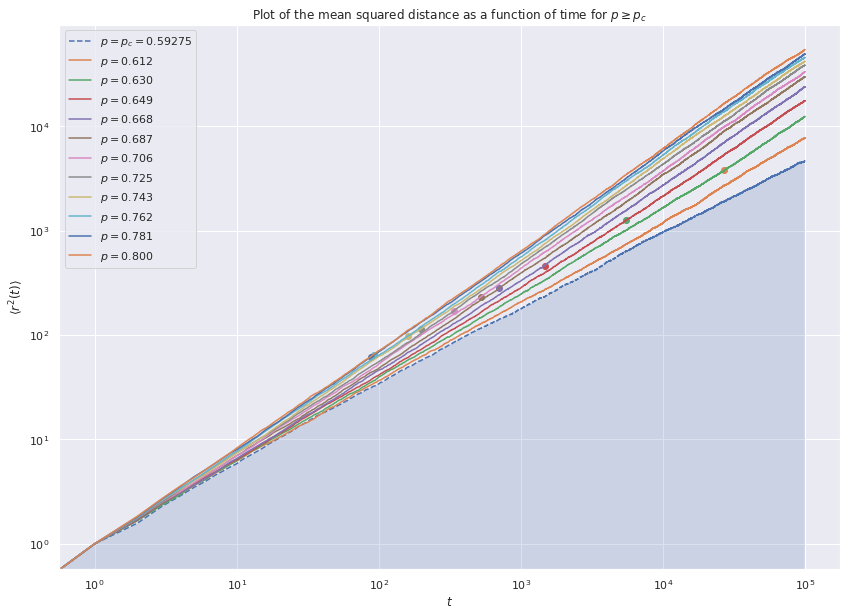

In [15]:
plt.figure(figsize=(14, 10))

plt.loglog(
    num_walks_arr,
    r_squared[0],
    "--",
    label=rf"$p = p_c = {p_c}$",
)
plt.fill_between(num_walks_arr, r_squared[0], alpha=0.2)

xi_squared_list = []
t_list = []
ind_list = []
p_list = []

for i, p in enumerate(p_arr[1:]):
    plt.loglog(
        num_walks_arr,
        r_squared[i + 1],
        label=rf"$p = {p:.3f}$"
    )

    mask = r_squared[0, 1:] <= 0.5 * r_squared[i + 1, 1:]

    if not np.any(mask):
        continue

    index = np.argmax(mask)

    xi_squared_list.append(r_squared[i + 1, index])
    t_list.append(num_walks_arr[index])
    ind_list.append(i + 1)
    p_list.append(p)

    plt.scatter(num_walks_arr[index], r_squared[i + 1, index])

plt.legend(loc="best")
plt.xlabel(r"$t$")
plt.ylabel(r"$\langle r^2(t) \rangle$")
plt.title(r"Plot of the mean squared distance as a function of time for $p \geq p_c$")
plt.show()

It is interesting to note that for a larger value of $p > p_c$ the cross-over time $t_0$ becomes smaller.
That is, for a higher percolation probability $p$ the time it takes for the system to behave as a "normal" random walker becomes shorter.
This also makes sense as there are fewer sites not contained in the spanning cluster.

Having found the points $(t_0, \xi^2)$ we now find an expression for $\nu$.
Taking the logarithm on both sides of the scaling ansatz for the characteristic length yields
\begin{align}
    \log(\xi) = \log(\xi_0) - \nu \log(p - p_c).
\end{align}
We use linear regression to find an expression for the intercept $\log(\xi_0)$ and the exponent $\nu$.

In [16]:
p_min_pc_arr = np.abs(np.array(p_list) - p_c)

clf = sklearn.linear_model.LinearRegression().fit(
    np.log(p_min_pc_arr)[:, np.newaxis],
    np.log(np.sqrt(xi_squared_list))[:, np.newaxis],
)

nu = -clf.coef_[0, 0]
log_xi_0 = clf.intercept_[0]

print(f"nu = {nu}")

nu = 1.1891154370180963


The exact value of $\nu$ in two dimensions is $\nu = 4/3$.

In [17]:
nu_exact = 4 / 3
print(f"nu_exact = {nu_exact}")

nu_exact = 1.3333333333333333


We therefore see that we are in ballpark range.
We plot the characteristic length as a function of $p$ and compare it to the theoretical scaling using our estimate of $\nu$.

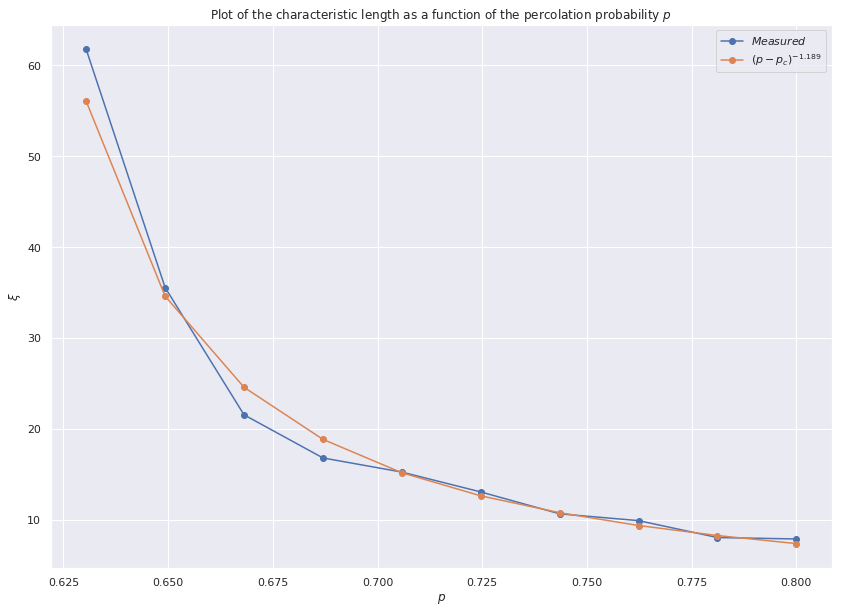

In [18]:
fig = plt.figure(figsize=(14, 10))

plt.plot(
    p_list,
    np.sqrt(xi_squared_list),
    "-o",
    label=r"$Measured$",
)
plt.plot(
    p_list,
    np.exp(log_xi_0) * p_min_pc_arr ** (-nu),
    "-o",
    label=r"$(p - p_c)^{-%.3f}$" % nu
)
#plt.plot(
#    p_list,
#    np.exp(log_xi_0) * p_min_pc_arr ** (-nu_exact),
#    "-o",
#    label=r"$(p - p_c)^{-%.3f}$" % nu_exact
#)
plt.xlabel(r"$p$")
plt.ylabel(r"$\xi$")
plt.title(r"Plot of the characteristic length as a function of the percolation probability $p$")
plt.legend(loc="best")
plt.show()

In this figure we see how our estimate of $\nu$ follows the measured data quite well.
And, more importantly, they follow the theoretical scaling using the exact value of $\nu$ closely.

In order to find an estimate for $x$ we need to find a value for $\mu$.
As we've stated earlier, when $p > p_c$ and $t \gg t_0$ which means that $r \gg \xi$ the random walker moves away from the anomalous diffusion and instead behaves as a free random walker with the relation
\begin{align}
    \langle r^2(t) \rangle = D(p) t.
\end{align}
The Einstein relation for diffusion relates the diffusion constant to the conductance through
\begin{align}
    D(p) \propto \sigma(p) \propto (p - p_c)^{\mu}.
\end{align}

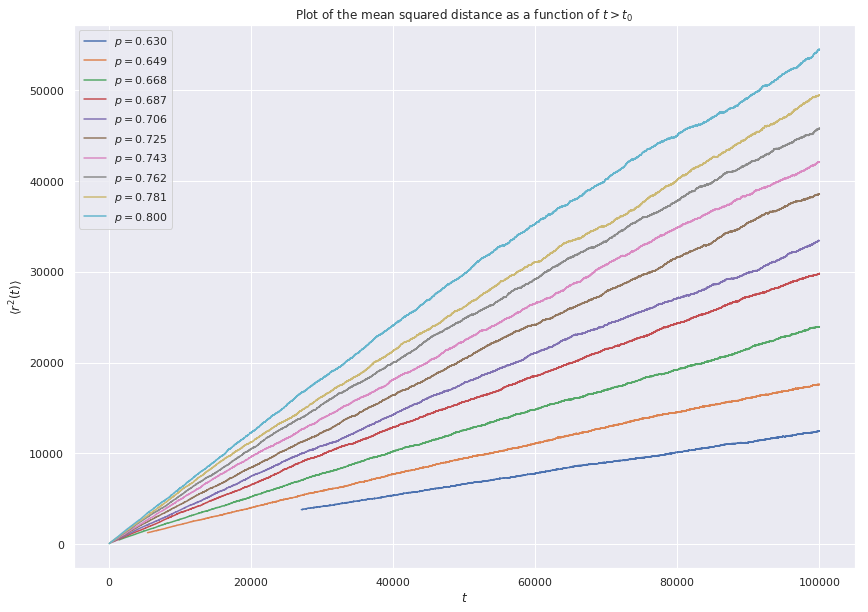

In [19]:
plt.figure(figsize=(14, 10))

diffusion_list = []
intercept_list = []
p_min_pc_diff_list = []

for i, p_i in enumerate(ind_list):
    t_0 = t_list[i]
    p = p_arr[p_i]

    p_min_pc_diff_list.append(p - p_c)

    cross = num_walks_arr > t_0

    t_cross = num_walks_arr[cross]
    r_cross = r_squared[p_i, cross]

    d, intercept = np.polyfit(t_cross, r_cross, deg=1)
    diffusion_list.append(d)
    intercept_list.append(intercept)

    plt.plot(t_cross, r_cross, label=fr"$p = {p:.3f}$")


plt.title(r"Plot of the mean squared distance as a function of $t > t_0$")
plt.xlabel(r"$t$")
plt.ylabel(r"$\langle r^2(t) \rangle$")
plt.legend(loc="best")
plt.show()

Ideally we expect the mean squared distance to be completely linear, however, we see that even though $t > t_0$ there are slight deviations to this trend.

Taking the logarithm on both sides of the scaling ansatz we are able to estimate $\mu$.
\begin{align}
    \log(D) \propto \mu \log(p - p_c).
\end{align}
Again we use the least squares method to estimate $\mu$.

In [20]:
mu, intercept = np.polyfit(np.log(p_min_pc_diff_list), np.log(diffusion_list), deg=1)

In [21]:
print(mu)

0.8802917007547179


From the lecture notes we know that the exact value of $\mu$ is given by $\mu = 1.3$.

In [22]:
mu_exact = 1.3

This shows that we miss by quite a lot when it comes to estimating $\mu$.

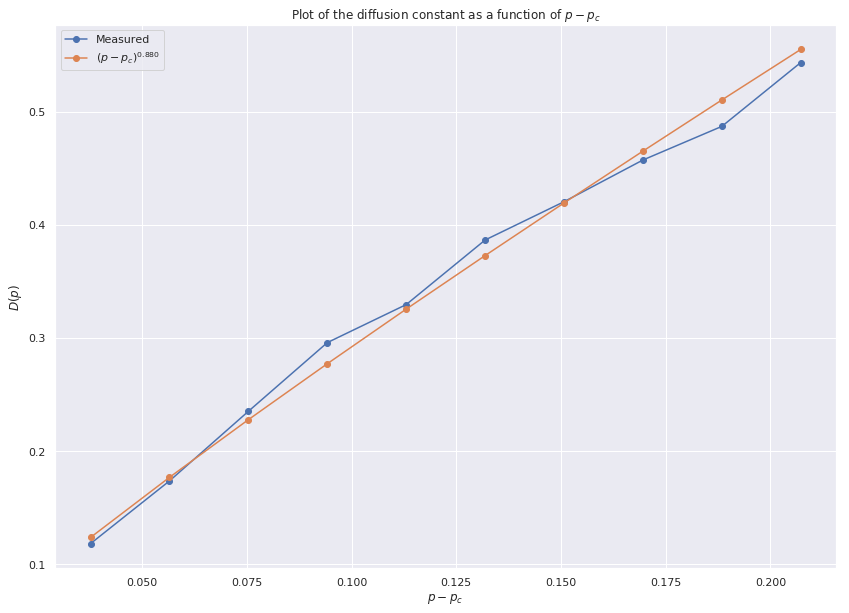

In [23]:
plt.figure(figsize=(14, 10))

plt.plot(
    p_min_pc_diff_list,
    diffusion_list,
    "-o",
    label=r"Measured",
)
plt.plot(
    p_min_pc_diff_list,
    np.exp(intercept) * np.array(p_min_pc_diff_list) ** (mu),
    "-o",
    label=r"$(p - p_c)^{%.3f}$" % mu,
)
plt.xlabel(r"$p - p_c$")
plt.ylabel(r"$D(p)$")
plt.title(r"Plot of the diffusion constant as a function of $p - p_c$")
plt.legend(loc="best")
plt.show()

In this figure we've plotted the diffusion constant as a function of $p - p_c$.
We compare the measured values with the theoretical scaling using our estimate of $\mu$.

In [28]:
x = (1 - 2 * k) / mu
print(f"x = {x}")

x = 0.3382710093761102


In [26]:
p_min_pc = p_arr[1:] - p_c
r_gg_xi = r_squared[1:, 1:]
t_sq = num_walks_arr[1:] ** (-2 * k)

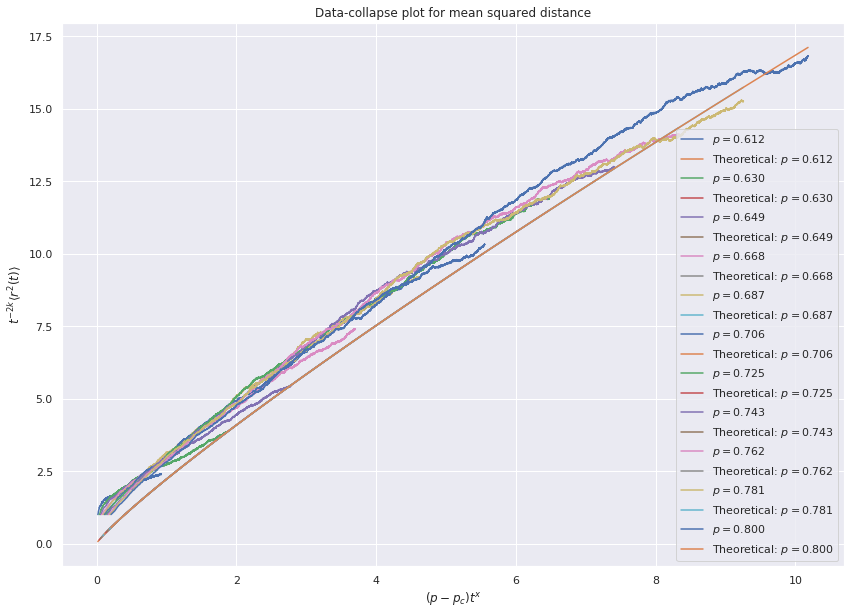

In [27]:
plt.figure(figsize=(14, 10))

for i in range(len(p_min_pc)):
    plt.plot(
        p_min_pc[i] * num_walks_arr[1:] ** (x),
        t_sq * r_gg_xi[i],
        label=fr"$p = {p_arr[i + 1]:.3f}$",
    )
    plt.plot(
        p_min_pc[i] * num_walks_arr[1:] ** (x),
        np.exp(intercept) * (p_min_pc[i] * num_walks_arr[1:] ** (x)) ** mu,
        label=fr"Theoretical: $p = {p_arr[i + 1]:.3f}$",
    )

plt.legend(loc="best")
plt.xlabel(r"$(p - p_c) t^{x}$")
plt.ylabel(r"$t^{-2k} \langle r^{2} (t)\rangle$")
plt.title(r"Data-collapse plot for mean squared distance")
plt.show()

In this figure we can see the data-collapse of the mean squared displacement.
We have compared to the theoretical scaling
\begin{gather}
    \langle r^2 \rangle \propto t^{2k} (p - p_c) t^{x}
    \propto t^{2k}\left[(p - p_c) t^{x}\right]^{\mu},
\end{gather}
where we use the intercept from the diffusion constant as the constant of proportionality.
We note that collapse isn't completely perfect, especially when $p$ is close to $p_c$.
A possible explanation to this is due to the percolation walker being restricted to a finite spanning cluster.
We might be able to alleviate some of this discrepancy if we allow the spanning cluster to have periodic boundaries, however this will require quite a lot of manipulation when labelling the spanning cluster and for the percolation walker and has therefore not been tested.